<a href="https://colab.research.google.com/github/zoedesimone/wwr-semantic-segmentation/blob/main/SegformerDatasetGeneration_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segformer Window Dataset Creation
This notebook creates an annotation and images dataset for segformer, using human annotation windows and superimposing results from a segformer pretrained model on ADE20K to segment buildings, trees etc.

using[ADE20K MIT Scene Parsing Benchchmark](http://sceneparsing.csail.mit.edu/).

### Environment Setup

First, download the code and pretrained models.

In [ ]:
%%bash
# Colab-specific setup
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
pip install yacs 2>&1 >> install.log
git init 2>&1 >> install.log
git remote add origin https://github.com/CSAILVision/semantic-segmentation-pytorch.git 2>> install.log
git pull origin master 2>&1 >> install.log
DOWNLOAD_ONLY=1 ./demo_test.sh 2>> install.log

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
From https://github.com/CSAILVision/semantic-segmentation-pytorch
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master


## Imports and utility functions

We need pytorch, numpy, and the code for the segmentation model.  And some utilities for visualizing the data.

In [ ]:
# System libs
import os, csv, torch, numpy, scipy.io, PIL.Image, torchvision.transforms
import pandas as pd
# Our libs
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode

colors = scipy.io.loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')

    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    # aggregate images and save
    im_vis = numpy.concatenate((img, pred_color), axis=1)
    display(PIL.Image.fromarray(im_vis))

In [ ]:
def save_result(img, pred, path, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')

    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)
    img = Image.fromarray(pred_color)

    # aggregate images and save

    img.save(path, optimize=True, quality=95)

## Loading the segmentation model

Here we load a pretrained segmentation model.  Like any pytorch model, we can call it like a function, or examine the parameters in all the layers.

After loading, we put it on the GPU.  And since we are doing inference, not training, we put the model in eval mode.

In [ ]:
SegmentationModule.forward

<function mit_semseg.models.models.SegmentationModule.forward(self, feed_dict, *, segSize=None)>

In [ ]:
# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth')
net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=2048,
    num_class=150,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth',
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
segmentation_module.eval()
segmentation_module.cuda()

Loading weights for net_encoder
Loading weights for net_decoder


SegmentationModule(
  (encoder): ResnetDilated(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): SynchronizedBatchNorm2d(128, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): SynchronizedBatchNorm2d(64, eps=1

In [ ]:
from PIL import Image

## Load test data

Now we load and normalize a single test image.  Here we use the commonplace convention of normalizing the image to a scale for which the RGB values of a large photo dataset would have zero mean and unit standard deviation.  (These numbers come from the imagenet dataset.)  With this normalization, the limiiting ranges of RGB values are within about (-2.2 to +2.7).

In [ ]:
import numpy as np

In [ ]:
output_dir = 'PredictedBuildings'
!mkdir PredictedBuildings
!mkdir Images

In [ ]:
#Download the datasets
# For the first file
!gdown 'https://drive.google.com/uc?id=1kDaFB298kmsFUCDuQkma5tdo_ORvlffY'
!unzip images.zip

# For the second file
!gdown 'https://drive.google.com/uc?id=1aZE2XUxYcfsl19kffZ0-_aMlHIXTtV-g'
!unzip annotations.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/01323.jpg        
  inflating: images/00882.jpg        
  inflating: images/02115.jpg        
  inflating: images/01615.jpg        
  inflating: images/00356.jpg        
  inflating: images/01508.jpg        
  inflating: images/02434.jpg        
  inflating: images/02011.jpg        
  inflating: images/00478.jpg        
  inflating: images/01778.jpg        
  inflating: images/00317.jpg        
  inflating: images/01024.jpg        
  inflating: images/00636.jpg        
  inflating: images/00995.jpg        
  inflating: images/00772.jpg        
  inflating: images/01869.jpg        
  inflating: images/00210.jpg        
  inflating: images/00419.jpg        
  inflating: images/02418.jpg        
  inflating: images/01483.jpg        
  inflating: images/00491.jpg        
  inflating: images/00457.jpg        
  inflating: images/00665.jpg        
  inflating: images/01832.jpg        
  inflating: images/00023.jpg        

In [ ]:
# Load and normalize one image as a singleton tensor batch
pil_to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
        std=[0.229, 0.224, 0.225])  # across a large photo dataset.
])

In [ ]:
directory = "images"
for filename in os.listdir(directory):
  pil_image = PIL.Image.open(directory+"/"+filename).convert('RGB')
  img_original = numpy.array(pil_image)
  img_data = pil_to_tensor(pil_image)
  singleton_batch = {'img_data': img_data[None].cuda()}
  output_size = img_data.shape[1:]

  # Run the segmentation at the highest resolution.
  with torch.no_grad():
      scores = segmentation_module(singleton_batch, segSize=output_size)

  # Get the predicted scores for each pixel
  _, pred = torch.max(scores, dim=1)
  pred = pred.cpu()[0].numpy()
  #visualize_result(img_original, pred)

  #Save predicted image in output_directory
  arr = np.random.randint(0, 256, (pred.shape[1], pred.shape[0], 3), dtype=np.uint8)
  img = Image.fromarray(arr)# Convert the ndarray into a PIL Image
  path = output_dir+"/"+filename
  save_result(img, pred, path, index=None)# Save the PIL Image as an image file

##Convert red pixels from out annotated data to Window colored pixels and apply those pixels to the predicted "building" images.

### Download red labeled images

In [ ]:
!mkdir MarkedWindow

In [ ]:
directory = "annotations"
out_dir = "MarkedWindow"

#filenames = ["00000.png"] #, "00001.png", "00002.png"
#for filename in filenames:

for filename in os.listdir(directory):
  # Load image 1 and convert it to a NumPy array
  img1 = Image.open(directory +'/'+filename)
  arr1 = np.array(img1)
  #img1.show()

  # Load image 2 and convert it to a NumPy array
  img2 = Image.open('PredictedBuildings/'+ filename.split(".")[0]+".jpg")
  #img2.show()
  arr2 = np.array(img2)
  #print(f"arr2 shape:{arr2.shape}")

  # Appy maks to image 1
  inv_mask = np.logical_not(np.logical_not(arr1))

  # Replace the matching pixels in image 2 with RGB value (230, 230, 230)
  arr2[inv_mask] = [230, 230, 230]

  # Convert the updated NumPy array back to a PIL Image and save it
  img_out = Image.fromarray(arr2)
  #img_out.show()

  # Save the PIL Image as an image file
  path = out_dir+"/"+filename.split(".")[0]+".png"

  img_out.save(path, quality='keep')

The dataset is already saved in [GoogleDrive](https://drive.google.com/drive/folders/1_QZlS601vPEbiGORTF3KWj8qoM1H08vo?usp=drive_link) so no need to save it again.

#If you want to skip the steps above, just download the datasets from GoogleDrive

In [ ]:
#Marked Windows
!gdown 'https://drive.google.com/uc?id=1jzS7mUAg49_jQmVpkmvz4TH5JXUCBl9d'
!unzip MarkedWindow.zip

##Caclulate the Building Facade, Window Area

Color encoding for segmantic segmentation for the pretrained model can be found here: https://docs.google.com/spreadsheets/d/1se8YEtb2detS7OuPE86fXGyD269pMycAWe2mtKUj2W8/edit#gid=0

Wall: RGB= (120, 120, 120), Hex = #787878

Building: RGB = (180, 120, 120), Hex = #B47878

Window: RGB = (230, 230, 230), Hex = #E6E6E6

skyscraper: RGB = (140, 140, 140), Hex = #8C8C8C

door;double;door RGB = (8, 255, 51), Hex = #08FF33

tree: RGB = (4, 200, 3), Hex = #04C803


In [ ]:
# Define the colors to count
colors = [(120, 120, 120), (180, 120, 120), (230, 230, 230), (140, 140, 140), (8, 255, 51), (4, 200, 3)]

# Define the directory path where the images are stored
dir_path = "MarkedWindow"
orig_dir_path = "images"

# Create an empty DataFrame to store the results
df = pd.DataFrame(columns=["fpath_img", "fpath_segm", "width", "height", "wall_px", "building_px", "window_px", "skyscraper_px", "door_px", "tree_px"])

# Loop through all the images in the directory
for filename in os.listdir(dir_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Open the image and get its width and height
        img = Image.open(os.path.join(dir_path, filename))
        filename_jpg_ext = filename.split(".")[0]+".jpg"
        width, height = img.size

        # Count the number of pixels of each color
        color_counts = [0, 0, 0, 0, 0 , 0]
        for x in range(width):
            for y in range(height):
                pixel = img.getpixel((x, y))
                for i, color in enumerate(colors):
                    if pixel == color:
                        color_counts[i] += 1

        # Append the results to the DataFrame
        df = df.append({"fpath_img": str(os.path.join(orig_dir_path, filename_jpg_ext)), #jpg
                        "fpath_segm": str(os.path.join(dir_path, filename)), #png
                        "width": width,
                        "height": height,
                        "wall_px": color_counts[0],
                        "building_px": color_counts[1],
                        "window_px": color_counts[2],
                        "skyscraper_px": color_counts[3],
                        "door_px": color_counts[4],
                        "tree_px": color_counts[5]},
                       ignore_index=True)

# Print the results
print(df)

# Save the DataFrame to a CSV file
df.to_csv('dataSegformer.csv', index=False)

Streaming output truncated to the last 5000 lines.
<ipython-input-24-939daef003b2>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"fpath_img": str(os.path.join(orig_dir_path, filename_jpg_ext)), #jpg
<ipython-input-24-939daef003b2>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"fpath_img": str(os.path.join(orig_dir_path, filename_jpg_ext)), #jpg
<ipython-input-24-939daef003b2>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"fpath_img": str(os.path.join(orig_dir_path, filename_jpg_ext)), #jpg
<ipython-input-24-939daef003b2>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df

In [ ]:
#create a column to store the WWR
df2 = df
df2["WWR"] = df2["window_px"]/ (df2["window_px"] + df2["building_px"])

In [ ]:
df2.to_csv('dataSegformerWWR.csv', index=False)

##Create an odgt file

These are also available on [GoogleDrive](https://drive.google.com/drive/folders/1-rGB0WGRfJeDYud8fR4btvVNtyd8ORIJ?usp=drive_link).
We follow a 60% train, 20% val, 20% test split
The semantic-segmentation odgt file naming convention can be found [here](https://raw.githubusercontent.com/CSAILVision/semantic-segmentation-pytorch/master/data/training.odgt).

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
df3 = df
#Shuffle the rows of the dataframe
df3 = df3.sample(frac=1).reset_index(drop=True)

# Split the dataframe into train and temp dataframes
train_df, temp_df = train_test_split(df3, test_size=0.4, random_state=42)

# Split the temp dataframe into test and validation dataframes
test_df, val_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Print the number of rows in each dataframe
print(f"Train dataframe has {len(train_df)} rows")
print(f"Test dataframe has {len(test_df)} rows")
print(f"Validation dataframe has {len(val_df)} rows")

ValueError: ignored

In [ ]:
#change the imagepaths in train
train_df["fpath_img"] = "images/training/"+ train_df["fpath_img"]
train_df["fpath_segm"] = "annotations/training/"+ train_df["fpath_segm"]

In [ ]:
#change the imagepaths in val
val_df["fpath_img"] = "images/validation/"+ val_df["fpath_img"]
val_df["fpath_segm"] = "annotations/validation/"+ val_df["fpath_segm"]

In [ ]:
#change the imagepaths in test
test_df["fpath_img"] = "images/test/"+ test_df["fpath_img"]
test_df["fpath_segm"] = "annotations/test/"+ test_df["fpath_segm"]

In [ ]:
# Open the output file for writing
with open('train.odgt', 'w') as f:
    # Iterate over each row of the dataframe
    for i, row in train_df.iterrows():
        # Construct a dictionary with the row data
        data = {
            'fpath_img': row['fpath_img'],
            'fpath_segm': row['fpath_segm'],
            'width': row['width'],
            'height': row['height']
        }
        # Write the dictionary to the output file
        f.write(str(data) + '\n')

In [ ]:
# Open the output file for writing
with open('val.odgt', 'w') as f:
    # Iterate over each row of the dataframe
    for i, row in val_df.iterrows():
        # Construct a dictionary with the row data
        data = {
            'fpath_img': row['fpath_img'],
            'fpath_segm': row['fpath_segm'],
            'width': row['width'],
            'height': row['height']
        }
        # Write the dictionary to the output file
        f.write(str(data) + '\n')

In [ ]:
# Open the output file for writing
with open('test.odgt', 'w') as f:
    # Iterate over each row of the dataframe
    for i, row in test_df.iterrows():
        # Construct a dictionary with the row data
        data = {
            'fpath_img': row['fpath_img'],
            'fpath_segm': row['fpath_segm'],
            'width': row['width'],
            'height': row['height']
        }
        # Write the dictionary to the output file
        f.write(str(data) + '\n')

This file can be later split into train and test

##Plot Dataset analytics

In [ ]:
df= pd.read_csv("dataSegformerWWR.csv")

df["WWR_round"] = df["WWR"].round(2)

print("mode")
print(df["WWR_round"].mode()[0])
print("mean")
print(df["WWR"].mean())
print("median")
print(df["WWR"].median())

mode
0.13
mean
0.1581144367679056
median
0.14650951986413202


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

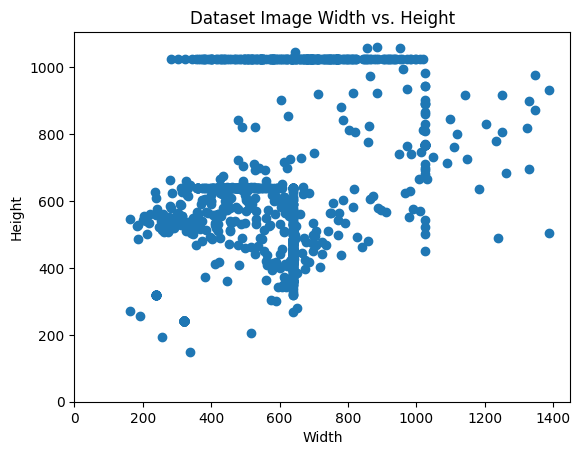

In [ ]:
# Assuming your dataframe is named df
x = df["width"]
y = df["height"]

plt.scatter(x, y)
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Dataset Image Width vs. Height")
plt.savefig("DatasetWidthVsHeight.svg",  bbox_inches="tight",
            pad_inches=0.3, transparent=True)
plt.show()


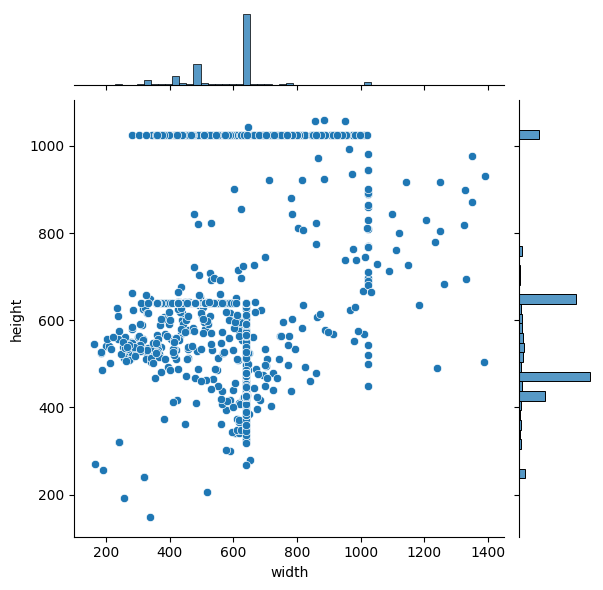

In [ ]:
sns.jointplot(data=df2, x="width", y="height")

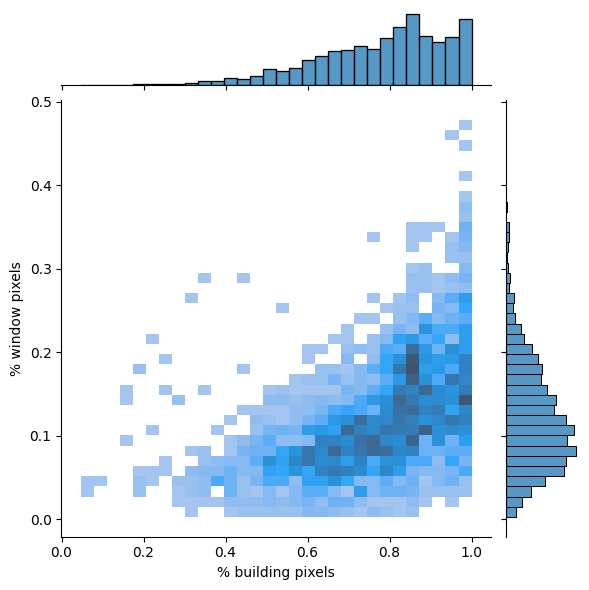

In [ ]:
df2["% building pixels"] = (df2["building_px"]+df2["window_px"])/ (df2["height"]*df2["width"])
df2["% window pixels"] = df2["window_px"]/ (df2["height"]*df2["width"])

sns.jointplot(data=df2, x="% building pixels", y="% window pixels", kind="hist")


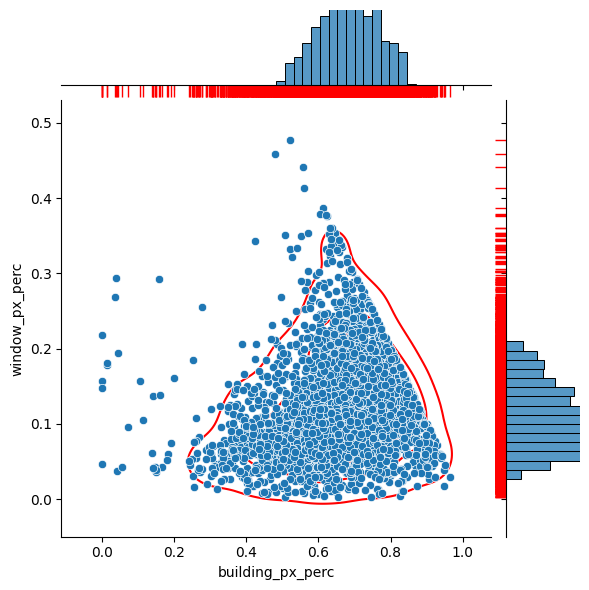

In [ ]:
g = sns.jointplot(data=df2, x="building_px_perc", y="window_px_perc")
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)
g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)

<Axes: xlabel='WWR', ylabel='Count'>

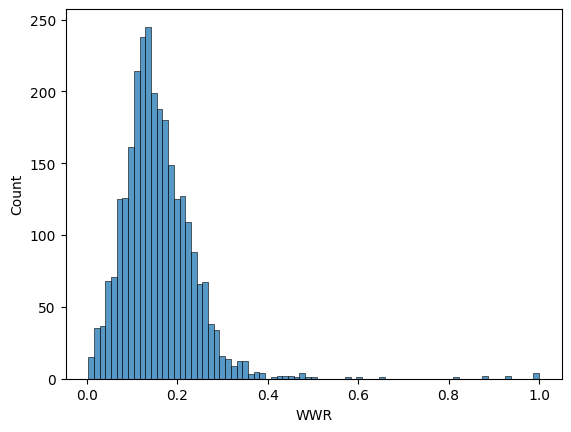

In [ ]:
sns.histplot(data=df2, x="WWR")

<Axes: xlabel='WWR', ylabel='Count'>

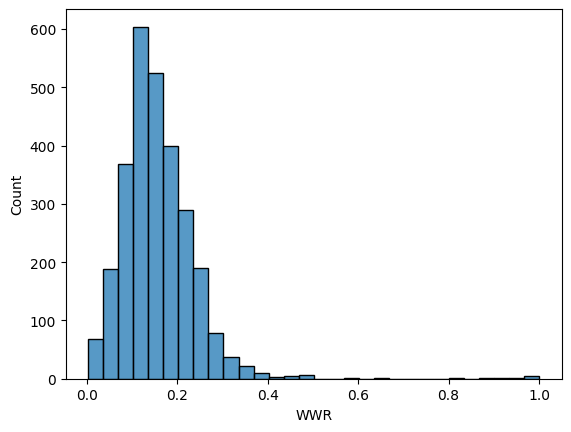

In [ ]:
sns.histplot(data=df2, x="WWR",bins=30)

In [ ]:
# Assuming your dataframe is named df
x = df["width"]
y = df["height"]

plt.scatter(x, y)
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Dataset Image Width vs. Height")
plt.savefig("DatasetWidthVsHeight.svg",  bbox_inches="tight",
            pad_inches=0.3, transparent=True)
plt.show()